# Exercise 10 - Handwritten Digits Recognition (Applied)

In [1]:
!pip install torch

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

print("Downloaded: train size =", len(train_full), ", test size =", len(test_set))

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]

Downloaded: train size = 60000 , test size = 10000


In [5]:
train_full[0][0], train_full[0][1]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

Sample tensor shape: torch.Size([1, 28, 28])  label: 5


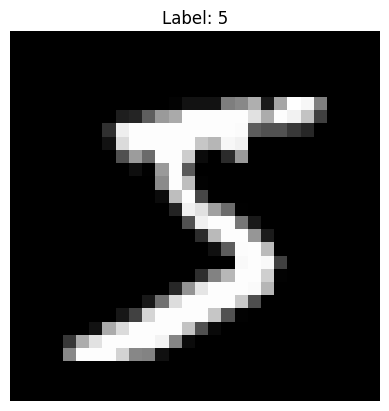

In [6]:
img, label = train_full[0]   # img is a tensor shape (1,28,28) after ToTensor
print("Sample tensor shape:", img.shape, " label:", label)
# To display, undo normalization for visualization
img_disp = img * 0.3081 + 0.1307   # invert normalization (approx)
plt.imshow(img_disp.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [7]:
val_size = 5000
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print("train_set:", len(train_set), " val_set:", len(val_set))

train_set: 55000  val_set: 5000


In [8]:
batch_size = 64
num_workers = 2  # increase if your machine supports it
pin_memory = True if torch.cuda.is_available() else False

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


### Simple Feedforward Neural Network - 1 Hidden Layer

In [9]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # first hidden layer
        self.fc2 = nn.Linear(128, 10)     # output layer (10 classes)

    def forward(self, x):
        # Flatten the 28x28 image to 784
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Accuracy of around ~ 6.50% with 5 Epochs

---

### Multilayer Feedforward Neural Network - 3 Hidden Layer

In [10]:
class FCSequentialMNIST(nn.Module):
    def __init__(self):
        super(FCSequentialMNIST, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),          # flatten 28x28 image → 784
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

Accuracy of around ~ 97.50% with 30 Epochs

---

### Simple CNN Model - 2 Conv layers, 1 Max Pool Layer

In [11]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super(CNNMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7,7))  # ensures fixed size
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)             # now guaranteed 7x7
        x = x.view(x.size(0), -1)            # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Accuracy of around ~ 98.70% with 30 Epochs

---

### LeNET (A CNN Model) - 2 Conv layers, 1 Pooling Layer in between

In [17]:
class LeNetMNIST(nn.Module):
    def __init__(self):
        super(LeNetMNIST, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)    # output: (28-5+1)=24 → 6x24x24
        self.pool = nn.AvgPool2d(2, 2)                # output: 6x12x12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # output: (12-5+1)=8 → 16x8x8
        # Fully connected layers
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes (digits)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # output logits
        return x

Accuracy of around ~ 98.50% with 30 Epochs

---

In [22]:
# Create model instance
model = LeNetMNIST()

# Loss function (for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD or Adam)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
# Assume train_loader and val_loader already created
num_epochs = 30

for epoch in range(num_epochs):
    model.train()  # training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move both images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Flatten image batch to (batch_size, 784)
        # images = images.view(-1, 28*28) # Not needed for CNN

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/30], Loss: 1.3013
Epoch [2/30], Loss: 0.3718
Epoch [3/30], Loss: 0.2648
Epoch [4/30], Loss: 0.2106
Epoch [5/30], Loss: 0.1737
Epoch [6/30], Loss: 0.1459
Epoch [7/30], Loss: 0.1276
Epoch [8/30], Loss: 0.1128
Epoch [9/30], Loss: 0.1024
Epoch [10/30], Loss: 0.0928
Epoch [11/30], Loss: 0.0861
Epoch [12/30], Loss: 0.0797
Epoch [13/30], Loss: 0.0745
Epoch [14/30], Loss: 0.0701
Epoch [15/30], Loss: 0.0657
Epoch [16/30], Loss: 0.0627
Epoch [17/30], Loss: 0.0590
Epoch [18/30], Loss: 0.0566
Epoch [19/30], Loss: 0.0540
Epoch [20/30], Loss: 0.0507
Epoch [21/30], Loss: 0.0486
Epoch [22/30], Loss: 0.0465
Epoch [23/30], Loss: 0.0444
Epoch [24/30], Loss: 0.0435
Epoch [25/30], Loss: 0.0409
Epoch [26/30], Loss: 0.0390
Epoch [27/30], Loss: 0.0379
Epoch [28/30], Loss: 0.0361
Epoch [29/30], Loss: 0.0350
Epoch [30/30], Loss: 0.0333


In [25]:
model.eval()  # evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        # Move both images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Flatten images
        # images = images.view(-1, 28*28)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Validation Accuracy: 98.14%


In [26]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Flatten the images for fully connected network
        # images = images.view(-1, 28*28)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 98.47%


So the acccuracy increase as we increase the complexity of the neural network.

Also, CNN models seem to perform overall better compared to just multilayer peceptron. Since convolution improves the breaking down of image thus imporving accuracy.